
# This notebook was done as practice on using ensemble learning methods.
## The dataset used is the UCI heart disease from kaggle.com. This dataset had binary classes, so it was easier to compare the model's performances using Area Under the Curve and the Receiver Operating Characteristic Curve.



In [1]:


# importing libraries.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier



In [2]:

# reading data from csv
# we are usiing the heart disease data set for binary classification

heart_df = pd.read_csv(r"C:\Users\KennoHead\Desktop\Data Science and Machine Learning Refresher\heart.csv")


In [3]:

# setting up the training and testing sets
heart_features_cols = list(heart_df.columns)
heart_features_cols.remove('target')
heart_features = heart_df[heart_features_cols]
heart_labels = heart_df['target']
X_training, X_testing, Y_training, Y_testing = train_test_split(heart_features, heart_labels, test_size = .3, random_state = 0)



In [4]:

# here we're going to do the bootstrap aggregation method with decision trees.

bootstrap_size = int(0.8 * len(X_training)) 
dec_tree_predict_list = []

for i in range(0, 30, 1):
    X_r_training = resample(X_training, n_samples = bootstrap_size, random_state = i, replace = True)
    Y_r_training = resample(Y_training, n_samples = bootstrap_size, random_state = i, replace = True)
    base_dec_tree = DecisionTreeClassifier(random_state = 0)
    base_dec_tree.fit(X_r_training, Y_r_training) 
    current_tree_prediction = base_dec_tree.predict(X_testing)
    dec_tree_predict_list.append(current_tree_prediction)
    
result_df = pd.DataFrame(data = dec_tree_predict_list)

result_df_trans = result_df.transpose().values.tolist()


In [5]:

bagging_predict_proba = []
bagging_predict = []

for current_row in result_df_trans:
    #print(current_row)
    current_row_counter = Counter (current_row)
    number_of_negatives = current_row_counter[0]
    number_of_positives = current_row_counter[1]
    
    prob_neg = number_of_negatives / len(current_row)
    prob_pos = number_of_positives / len(current_row)
    
    bagging_predict_proba.append([prob_neg, prob_pos])
    
    if current_row_counter[1] > current_row_counter[0]:
        bagging_predict.append(1)
    elif current_row_counter[0] > current_row_counter[1]:
        bagging_predict.append(0)
    else:
        bagging_predict.append(0)

bagging_predict_proba_nparray = np.array(bagging_predict_proba)


In [6]:

bagging_acc_rate = accuracy_score(Y_testing, bagging_predict)
BAG_FPR, BAG_TPR, BAG_thresholds = metrics.roc_curve(Y_testing, bagging_predict_proba_nparray[:,1], pos_label = 1)
BAG_AUC = metrics.auc(BAG_FPR, BAG_TPR)

print('Bagging method accuracy ' + str(bagging_acc_rate))
print('Bagging method AUC ' + str(BAG_AUC))


Bagging method accuracy 0.8461538461538461
Bagging method AUC 0.8815280464216635


In [7]:

# using adaptive boosting classifier
adaboost = AdaBoostClassifier(n_estimators = 30, random_state = 0)
adaboost.fit(X_training, Y_training)
adaboost_predictions = adaboost.predict(X_testing)
adaboost_accuracy = accuracy_score(Y_testing, adaboost_predictions)
adaboost_probabilities = adaboost.predict_proba(X_testing)

ADB_FPR, ADB_TPR, ADB_thresholds = metrics.roc_curve(Y_testing, adaboost_probabilities[:,1], pos_label = 1)
ADB_AUC = metrics.auc(ADB_FPR, ADB_TPR)

print('AdaboostClassifier accuracy ' + str(adaboost_accuracy))
print('AdaboostClassifier AUC ' + str(ADB_AUC))


AdaboostClassifier accuracy 0.8021978021978022
AdaboostClassifier AUC 0.8462282398452612


In [8]:

# using extreme gradient classifier
xgboost = XGBClassifier( n_estimators = 30, random_state = 0, use_label_encoder = False)
xgboost.fit(X_training, Y_training, eval_metric = 'logloss')
xgboost_predictions = xgboost.predict(X_testing)
xgboost_accuracy = accuracy_score(Y_testing, xgboost_predictions)
xgboost_probabilities = xgboost.predict_proba(X_testing)

XGB_FPR, XGB_TPR, XGB_thresholds = metrics.roc_curve(Y_testing, xgboost_probabilities[:,1], pos_label = 1)
XGB_AUC = metrics.auc(XGB_FPR, XGB_TPR)

print('XGBoostClassifier accuracy ' + str(xgboost_accuracy))
print('XGBoostClassifier AUC ' + str(XGB_AUC))


XGBoostClassifier accuracy 0.7912087912087912
XGBoostClassifier AUC 0.8878143133462283


In [9]:

# using random forest classifier
rfc = RandomForestClassifier(n_estimators = 30, bootstrap = True, random_state = 0)
rfc.fit(X_training, Y_training)
rfc_predictions = rfc.predict(X_testing)
rfc_accuracy = accuracy_score(Y_testing, rfc_predictions)
rfc_probabilities = rfc.predict_proba(X_testing)

RFC_FPR, RFC_TPR, RFC_thresholds = metrics.roc_curve(Y_testing, rfc_probabilities[:,1], pos_label = 1)
RFC_AUC = metrics.auc(RFC_FPR, RFC_TPR)

print('RandomForestClassifier accuracy ' + str(rfc_accuracy))
print('RandomForestClassifier AUC ' + str(RFC_AUC))


RandomForestClassifier accuracy 0.7912087912087912
RandomForestClassifier AUC 0.8890232108317214


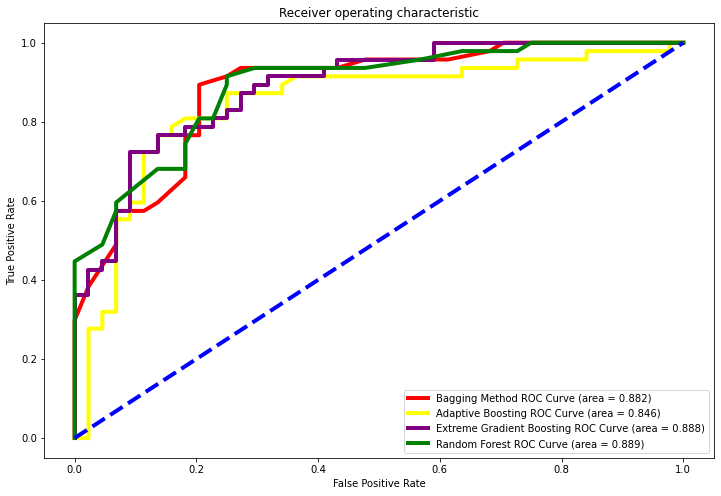

In [11]:

# using matplotlib to visualize the receiver operating characteristic curve
# of each ensemble learning method
# note that we did not modify the data much
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(BAG_FPR, BAG_TPR, color ='red', lw = 4, label = 'Bagging Method ROC Curve (area = %0.3f)' % BAG_AUC)
plt.plot(ADB_FPR, ADB_TPR, color ='yellow', lw = 4, label = 'Adaptive Boosting ROC Curve (area = %0.3f)' % ADB_AUC)
plt.plot(XGB_FPR, XGB_TPR, color ='purple', lw = 4, label = 'Extreme Gradient Boosting ROC Curve (area = %0.3f)' % XGB_AUC)
plt.plot(RFC_FPR, RFC_TPR, color ='green', lw = 4, label = 'Random Forest ROC Curve (area = %0.3f)' % RFC_AUC)

# random guess plot
plt.plot([0, 1], [0, 1], color='blue', lw = 4, linestyle='--')

# plot legends
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



# AUC Results would show that the XGBoost (purple curve) would perform better using TPR vs FPR, despite having lower AUC value than Random Forest. XGBoost and Random Forest both tie in accuracy (79.12%) in this case.
